In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
# import tensorflow as tf
import numpy as np
import cv2
import shutil
import seaborn as sns
import random
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

In [4]:
folders = os.listdir('gear_images')
for folder in folders:
    os.mkdir(os.path.join("Dataset", "Train", folder))
    os.mkdir(os.path.join("Dataset", "Test", folder))
    os.mkdir(os.path.join("Dataset", "Validation", folder))

In [6]:
for folder in folders:
    files = os.listdir(os.path.join("gear_images", folder))
    random.shuffle(files)
    m = len(files)
    
    train_files = files[0 : int( 0.7 * m)]
    validation_files = files[int( 0.7 * m) : int( 0.85 * m)]
    test_files = files[int( 0.85 * m) :]
    
    for file in train_files:
        shutil.copy(os.path.join("gear_images", folder, file), os.path.join("Dataset", "Train", folder, file))
    for file in validation_files:
        shutil.copy(os.path.join("gear_images", folder, file), os.path.join("Dataset", "Validation", folder, file))
    for file in test_files:
        shutil.copy(os.path.join("gear_images", folder, file), os.path.join("Dataset", "Test", folder, file))

Predicted : hardshell_jackets
Probability : 0.964253247


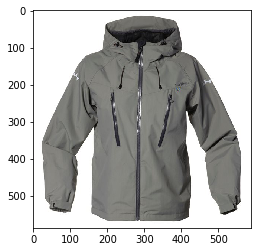

In [39]:
vision_base_url = "https://southcentralus.api.cognitive.microsoft.com/customvision/v1.1/Prediction/3620a4fa-71b9-41cf-b8b8-6b68437e56ee/url?iterationId=88c06f9c-14e7-44e2-a9a7-3897ea69df59" 
subscription_key = "a119055489f94732bcf36f91356437a2"
assert subscription_key
vision_analyze_url = vision_base_url# + "analyze"
image_url = "http://www.isbjornofsweden.com/images/2.5747/isbjorn-monsune-hardshell-jacket.jpeg"
# image_url = "https://images.pexels.com/photos/104827/cat-pet-animal-domestic-104827.jpeg?auto=compress&cs=tinysrgb&h=350"

from urllib.request import urlopen
f = open('test.jpg','wb')
f.write(urlopen(image_url).read())
f.close()

img = Image.open('test.jpg')
imshow(np.asarray(img))

Content_Type = "application/json"

import requests
headers  = {'Prediction-Key': subscription_key , 'Content-Type' : Content_Type}
# params   = {'visualFeatures': 'Categories,Description,Color'}
data     = {'url': image_url}
response = requests.post(vision_analyze_url, headers=headers, json=data)
response.raise_for_status()
analysis = response.json()
# print(analysis['Predictions'])

predictions = analysis['Predictions']
prob = 0
class_name = ""

for pred in predictions:
    if prob < pred['Probability']:
        prob = pred['Probability']
        class_name = pred["Tag"]

if prob < 0.90:
    print("Predicted : Others")
else:
    print("Predicted : " + class_name)
    print("Probability : " + str(prob))

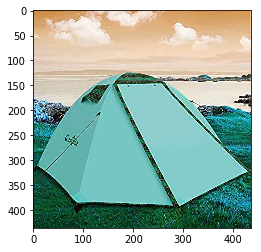

In [2]:
desired_size = 128
im_pth = "Dataset/Train/tents/51cQJ0cyE5L._AC_US436_QL65_.jpg"

im = cv2.imread(im_pth)
imshow(np.asarray(im))

In [14]:
def resize_and_pad(im, desired_shape = 128):
    old_size = im.shape[:2] # old_size is in (height, width) format
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    return new_im

In [4]:
def histequal(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

    # convert the YUV image back to RGB format
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    
    return img_output

In [7]:
def histogram(img):
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()
    # plt.plot(cdf_normalized, color = 'g')
    plt.hist(img.flatten(),256,[0,256], color = 'b')
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    plt.show()

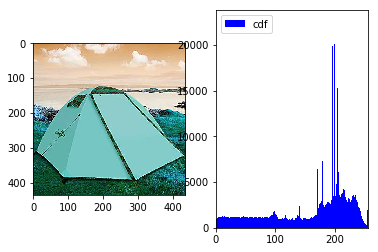

In [8]:
img = cv2.imread('Dataset/Train/tents/51cQJ0cyE5L._AC_US436_QL65_.jpg')
plt.subplot(121)
imshow(img)
plt.subplot(122)
histogram(img)

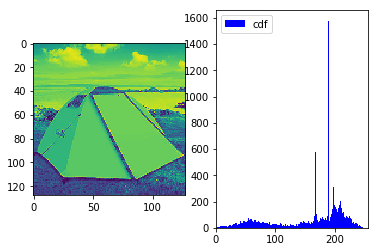

In [9]:
imgr = resize_and_pad(img)
plt.subplot(121)
imshow(imgr)
plt.subplot(122)
histogram(imgr)

In [10]:
equ = histequal(imgr)
plt.subplot(121)
imshow(equ)
plt.subplot(122)
histogram(equ)

error: C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:11144: error: (-215) scn == 3 || scn == 4 in function cv::cvtColor


In [ ]:
print(np.unique(equ))

In [ ]:
stc = np.hstack((imgr, equ))
imshow(stc)

In [15]:
sets = ["Train", "Validation", "Test"]
class_names = ["axes", "boots", "carabiners", "crampons", "gloves", "hardshell_jackets", "harnesses", "helmets", "insulated_jackets", "pulleys", "rope", "tents"]

for s in sets:
    data = []
    labels = []
    folders = os.listdir(os.path.join("Dataset", s))
    for folder in folders:
        label = class_names.index(folder)
        files = os.listdir(os.path.join("Dataset", s, folder))
        for file in files:
            img = cv2.imread(os.path.join("Dataset", s, folder, file))
            img = resize_and_pad(img)
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.equalizeHist(img)
            
            img = img / 255
            
            data.append(img)
            labels.append(label)
    
    data = np.array(data).reshape((-1, 128, 128, 1))
    labels = np.array(labels).reshape((-1))
    
    np.save("Data/" + s + "_data.npy", data)
    np.save("Data/" + s + "_labels.npy", labels)

In [16]:
from sklearn import datasets, svm, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

train_data = np.load("Data/Train_data.npy")
train_labels = np.load("Data/Train_labels.npy")
val_data = np.load("Data/Validation_data.npy")
val_labels = np.load("Data/Validation_labels.npy")
test_data = np.load("Data/test_data.npy")
test_labels = np.load("Data/test_labels.npy")

val_data = val_data.reshape((val_data.shape[0], -1))
test_data = test_data.reshape((test_data.shape[0], -1))
m = train_data.shape[0]

train_data = train_data.reshape((m, -1))

print("Train Data : " + str(train_data.shape))
print("Train Labels : " + str(train_labels.shape))

print("Validation Data : " + str(val_data.shape))
print("Validation Labels : " + str(val_labels.shape))

print("Test Data : " + str(test_data.shape))
print("Test Labels : " + str(test_labels.shape))

Train Data : (1480, 16384)
Train Labels : (1480,)
Validation Data : (318, 16384)
Validation Labels : (318,)
Test Data : (324, 16384)
Test Labels : (324,)


In [17]:
train_data = np.concatenate((train_data, val_data))
train_labels = np.concatenate((train_labels, val_labels))

In [18]:
print("Train Data : " + str(train_data.shape))
print("Train Labels : " + str(train_labels.shape))

Train Data : (1798, 16384)
Train Labels : (1798,)


In [21]:
from urllib.request import urlopen

def get_img(image_url):
    # image_url = "https://3.imimg.com/data3/QD/HN/MY-678214/helmet-250x250.jpg"
    # image_url = "https://images-na.ssl-images-amazon.com/images/I/51Q0Ph9JmdL.jpg"
    f = open('test.jpg','wb')
    f.write(urlopen(image_url).read())
    f.close()

    img = cv2.imread("test.jpg")
    imshow(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = resize_and_pad(img)
    img = cv2.equalizeHist(img)
    img = img / 255
    return img
# get_img("https://shop.epictv.com/sites/default/files/ae42ad29e70ba8ce6b67d3bdb6ab5c6e.jpeg")

# SVM

In [ ]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]}]

svm_clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=5)

svm_clf.fit(train_data, train_labels)

# classifier = svm.SVC(kernel = 'rbf')
# classifier.fit(train_data, train_labels)

In [ ]:
expected = test_labels
predicted = svm_clf.predict(test_data)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

print("Accuracy : " + str(accuracy_score(expected, predicted)))

Predicted : hardshell_jackets


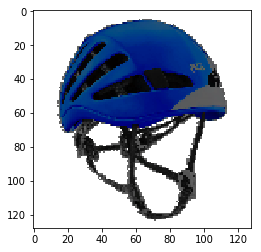

In [162]:
image_url = "https://shop.epictv.com/sites/default/files/ae42ad29e70ba8ce6b67d3bdb6ab5c6e.jpeg"
img = get_img(image_url)
imshow(img)
img = img.reshape((-1, 128 * 128 * 3))
predicted = classifier.predict(img)
print("Predicted : " + class_names[predicted[0]])

# Random Forest

In [ ]:
tuned_parameters = {
   'n_estimators': [50, 100, 200, 500],
   'max_features': ['auto', 'sqrt', 'log2'],
   'criterion' :['gini', 'entropy']
}

rf_clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5)

# pca = PCA(n_components=100)

# principalComponents = pca.fit_transform(train_data)
# print(pca.explained_variance_ratio_)
# clf = RandomForestClassifier(n_estimators = 24)
# clf = clf.fit(train_data, train_labels)
rf_clf = rf_clf.fit(train_data, train_labels)

In [23]:
clf = RandomForestClassifier(n_estimators = 24)
clf = clf.fit(train_data, train_labels)

In [ ]:
expected = test_labels
predicted = rf_clf.predict(test_data)

print("Classification report for classifier %s:\n%s\n"
      % (rf_clf, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

print("Accuracy : " + str(accuracy_score(expected, predicted)))

Predicted : helmets


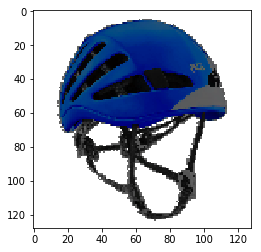

In [163]:
image_url = "https://shop.epictv.com/sites/default/files/ae42ad29e70ba8ce6b67d3bdb6ab5c6e.jpeg"
img = get_img(image_url)
imshow(img)
img = img.reshape((-1, 128 * 128 * 3))
predicted = clf.predict(img)
print("Predicted : " + class_names[predicted[0]])